In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import os

## Load data

In [34]:
path_to_data = '/home/dafne/shared/FilterBubble/topic-modeling/'
fname = os.path.join(path_to_data, 'texts_rens.csv')

data = pd.read_csv(fname)

In [4]:
data.shape

(98735, 11)

In [21]:
# These are taken from the pdf
topic_names = {
            1:'Macroeconomics',
            2: 'Civil rights and minority issues',
            3: 'Health',
            4: 'Agriculture',
            5: 'Labor and employment',
            6: 'Education',
            7: 'Environment',
            8: 'Energy',
            9: 'Immigration and integration',
            10: 'Transportation',
            12: 'Law and crime',
            13: 'Social welfare',
            14: 'Community development and housing',
            15: 'Banking, finance, and commerce',
            16: 'Defense',
            17: 'Science, technology, and communication',
            18: 'International trade',
            19: 'International affairs and foreign aid',
            20: 'Government operations',
            21: 'Spatial planning',
            23: 'Art, culture and entertainment',
            24: 'Local government',
            27: 'Weather and natural disasters',
            28: 'Fires and accidents',
            29: 'Sports and recreation',
            30: 'Obituary',
            31: 'Churches and religion',
            99: 'Other issue'
}

In [5]:
data.head()

,aid,id,date,outlet,headline,text,economic,conflict,human,topic_all,topic_six
0,74211078,#10 @20461 +2552,2004-12-29,De Telegraaf,GIFTEN STROMEN BINNEN,"Van een onzer verslaggeefsters\n\nDEN HAAG, wo...",1.0,0.0,1.0,23.0,1.0
1,74236286,#10 @33835 +1498,1995-12-30,de Volkskrant,No headline found!,Uiterlijk: baard en snor en pijp en pet en som...,0.0,0.0,1.0,4.0,6.0
2,74185091,#10 @34551 +3253,1995-12-29,NRC Handelsblad,No headline found!,"ROTTERDAM, 29 DEC. Burgemeester dr. A. Peper v...",1.0,1.0,1.0,10.0,6.0
3,74152890,#10 @35065 +7959,1999-02-08,NRC Handelsblad,Jordanie begraaft koning Hussein ; Clinton en ...,Sinds de moskeeen gistermiddag Koranverzen beg...,0.0,1.0,1.0,19.0,1.0
4,74164670,#10 @35065 +7959,1999-02-08,NRC Handelsblad,Jordanie begraaft koning Hussein ; Clinton en ...,Sinds de moskeeen gistermiddag Koranverzen beg...,0.0,1.0,1.0,19.0,1.0


In [111]:
data['topic_name'] = [topic_names.get(i, np.nan) for i in data.topic_all]

## Explore topics

In [125]:
# What are the topic_six categories?
for topic in sorted(data.topic_six.unique()):
    print(topic)
    print(data[data.topic_six==topic].topic_name.value_counts())

1.0
International affairs and foreign aid     9945
Defense                                   2531
Art, culture and entertainment             912
Civil rights and minority issues           510
Government operations                      397
Sports and recreation                      331
Law and crime                              319
Fires and accidents                        291
Weather and natural disasters              224
Immigration and integration                221
Other issue                                206
Obituary                                   107
Science, technology, and communication      91
Education                                   85
Churches and religion                       85
Banking, finance, and commerce              55
Health                                      44
Transportation                              33
Macroeconomics                              33
Community development and housing           17
Energy                                      16
Labor and

In [118]:
# Check headlines of topics
for topic in data.topic_name.value_counts().index:
    print(topic)
    print(data[data.topic_name==topic].headline[:30].values)
    print('\n')

Art, culture and entertainment
['GIFTEN STROMEN BINNEN' 'No headline found!' 'Fritz Behrendt overleden'
 'Louis Vuitton strikt Madonna' 'Te kijk'
 'Vooral sinds de verloving gaat het hard met Maxima(R)'
 "'Ik probeer het leven te nemen zoals het is '"
 'Surfen over het San Marcoplein' "'Ik heb dat frikkerige wel in me'"
 "Meer seks dan rock 'n roll bij Ten Damme"
 'Russische media uit handen buitenlanders' 'Doutzen in ondergoed'
 'Uitlaatstrook' 'Tuinman' 'ABSINT' 'De filmregisseur als dienstmeid'
 'De filmregisseur als dienstmeid' 'WEBBY AWARDS (4/4)'
 'Doutzen engel in New York' 'Koninklijke eer voor Jiri Kylian'
 'Handkus voor de Koningin' 'LUCHTJE?'
 'Schrijven over de oorlog is altijd moreel geladen'
 "De neergang van het postzegels sparen; Kwijnende koning der hobby's"
 "De neergang van het postzegels sparen; Kwijnende koning der hobby's"
 'Chat met Daphne' 'Koning Oedipus bij premiere de kluts kwijt'
 '26 Rebecca eruit' 'Elk geluid plantte zich voort'
 'Elk geluid plantte zich v

['Burger eist lagere rente Later naar Mars' 'van plukken'
 'Kabinet akkoord over begroting'
 "Haatmoskee volgens fiscus 'algemeen nut'"
 'De vlucht naar voren van Zalm'
 'Akkoord kabinet over extra uitgaven ;\xa0Acht miljard in 2002'
 'Groei economie VS verrassend hoog: 2 procent'
 'Verlaging pensioen is reële optie' 'Koopkracht neemt toe'
 'Euforie beleggers na onverwachte renteverlaging'
 'Zalm bereid tot extra geld voor investeringen'
 'Lokale heffingen schieten omhoog'
 'Begrotingsregels van Zalm onder groeiende druk'
 'Oppositie: milieu en lage inkomens dupe van kabinet'
 'Oppositie: milieu en lage inkomens dupe van kabinet'
 "'ALLE HENS AAN DEK'" 'Korte vreugde op beurzen over renteverlaging'
 'Supermarkt-taks erbij' 'Benzineprijs daalt verder'
 'Consument minder somber' 'Beurzen bereiken nieuw dieptepunt'
 'Loonstrookje hoger in 2009' 'Voedselprijzen hoger door crisis landbouw'
 'Henk Don wensdenkt voor de politiek' 'Extra impuls voor economie'
 'Senaat hakt in plan Bush' 'Staan

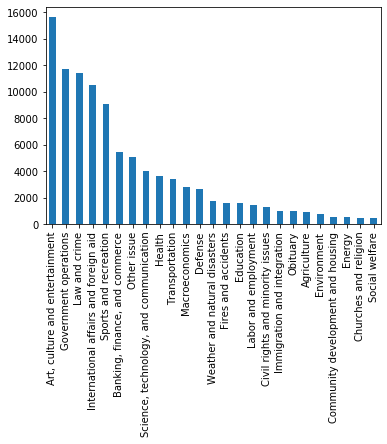

In [113]:
data.topic_name.value_counts().plot(kind='bar')

## Data cleaning / selection

In [30]:
data[data.text.isna()]

,aid,id,date,outlet,headline,text,economic,conflict,human,topic_all,topic_six
4977,74200285,#11434 @18884051 +558,2008-04-21,De Telegraaf,STRIJD DER GIGANTEN,NaN,0.0,0.0,0.0,23.0,5.0
74101,74179111,#36321 @87916263 +2414,2011-02-15,NRC Handelsblad,No headline found!,NaN,1.0,0.0,0.0,1.0,2.0


In [35]:
topic_sub = [9, 1, 27]
print('Topic names:')
for t in topic_sub:
    print(topic_names[t])

Topic names:
Immigration and integration
Macroeconomics
Weather and natural disasters


In [132]:
data_sub = data[data.topic_all.isin(topic_sub)].dropna(subset=['text'])
#data_sub = data.dropna(subset=['text', 'topic_six']).sample(5000)

## NLP processing

In [1]:
import stanfordnlp
#stanfordnlp.download('nl')

In [170]:
nlp = stanfordnlp.Pipeline(lang='nl', processors='tokenize,mwt,pos,lemma')

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/dafne/stanfordnlp_resources/nl_alpino_models/nl_alpino_tokenizer.pt', 'lang': 'nl', 'shorthand': 'nl_alpino', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/dafne/stanfordnlp_resources/nl_alpino_models/nl_alpino_tagger.pt', 'pretrain_path': '/home/dafne/stanfordnlp_resources/nl_alpino_models/nl_alpino.pretrain.pt', 'lang': 'nl', 'shorthand': 'nl_alpino', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/dafne/stanfordnlp_resources/nl_alpino_models/nl_alpino_lemmatizer.pt', 'lang': 'nl', 'shorthand': 'nl_alpino', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
Done loading processors!
---


In [171]:
## This takes time...
processed_corpus = [nlp(doc) for doc in corpus]

In [172]:
lemmas = [[w.lemma for s in doc.sentences for w in s.words] for doc in processed_corpus]

In [174]:
lemma_strings = [' '.join(l) for l in lemmas]

In [176]:
data_sub['lemmas'] = lemma_strings

In [178]:
data_sub.to_csv(os.path.join(path_to_data, 'data_sub.csv'), index=False)

In [4]:
data_sub = pd.read_csv(os.path.join(path_to_data, 'data_sub.csv'))

## Classification pipeline

In [6]:
data_sub[['text', 'lemmas']]

,text,lemmas
0,SAMENVATTING\n\ndoor Ronald van Gessel AM...,samenvatting door Ronald van Gessel Amsterdam ...
1,"door Arianne Mantel\n\nDEN BOSCH, vrijdag\n\nN...","door Arianne Mantel DEN BOSCH , vrijdag Nederl..."
2,"Van een onzer\n\nverslaggevers\n\nAMSTERDAM,\n...","van een onzer verslaggever Amsterdam , donderd..."
3,Het kabinet is het eens over de begroting voor...,het kabinet zijn het eens over de begroting vo...
4,De vermoedelijke zoon van de Noord-Koreaanse l...,de vermoedelijk zoon van de Noord-Koreaans lei...
...,...,...
5471,Een loon-prijsspiraal is de belangrijkste bedr...,een loon-prijsspiraal zijn de belangrijk bedre...
5472,SAMENVATTING\n\nVan onze verslaggevers DEN HAA...,"samenvatting van ons verslaggever DEN HAAG , d..."
5473,De consumentenprijzen in Nederland zijn in apr...,de consumentenprijs in Nederland zijn in april...
5474,SAMENVATTING\n\ndoor Dennis Naaktgeboren en Me...,samenvatting door Dennis Naaktgeboar en Menzo ...


In [7]:
y = data_sub.topic_all

In [8]:
#corpus = data_sub.text.values
corpus = data_sub.lemmas.values

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [12]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9)
X = vectorizer.fit_transform(corpus)

In [13]:
X.shape

(5476, 11146)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [26]:
tf_transformer = TfidfTransformer().fit(X_train)
X_train_tf = tf_transformer.transform(X_train)
X_test_tf = tf_transformer.transform(X_test)

In [27]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, y_train)

In [28]:
predicted = clf.predict(X_test_tf)

In [29]:
from sklearn import metrics
target_names = [topic_names[i] for i in sorted(topic_sub)]
print(metrics.classification_report(y_test, predicted, target_names=target_names))

                               precision    recall  f1-score   support

               Macroeconomics       0.91      1.00      0.95       912
  Immigration and integration       1.00      0.80      0.89       333
Weather and natural disasters       1.00      0.96      0.98       563

                     accuracy                           0.95      1808
                    macro avg       0.97      0.92      0.94      1808
                 weighted avg       0.96      0.95      0.95      1808



In [30]:
pd.DataFrame(metrics.confusion_matrix(y_test, predicted), index=target_names, columns=target_names)

,Macroeconomics,Immigration and integration,Weather and natural disasters
Macroeconomics,911,0,1
Immigration and integration,64,268,1
Weather and natural disasters,21,0,542
